In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed_data_mini/tensorflow2/default/1/validation_data.parquet
/kaggle/input/preprocessed_data_mini/tensorflow2/default/1/training_data.parquet
/kaggle/input/js_1100_scaled/tensorflow2/default/1/validation_data.parquet
/kaggle/input/js_1100_scaled/tensorflow2/default/1/training_data.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market

# Data Prepare & Libraries

In [2]:
pip install neuralprophet -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 19.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import polars as pl
import gc

from datetime import timedelta
#from prophet import Prophet
from neuralprophet import NeuralProphet

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
sample_df = pl.scan_parquet(
    f"/kaggle/input/preprocessed_data_mini/tensorflow2/default/1/training_data.parquet"
).collect().to_pandas()

validation_df = pl.scan_parquet(
    f"/kaggle/input/preprocessed_data_mini/tensorflow2/default/1/validation_data.parquet"
).collect().to_pandas()

daily_df = pl.scan_parquet(
    f"/kaggle/input/js_1100_scaled/tensorflow2/default/1/training_data.parquet" 
).collect().to_pandas()

daily_val_df = pl.scan_parquet(
    f"/kaggle/input/js_1100_scaled/tensorflow2/default/1/validation_data.parquet"
).collect().to_pandas()

In [5]:
gc.collect()

150

# Preprocessing

In [6]:
start_date = pd.Timestamp("2020-01-01") # 시작 기준일(임의)

def data_to_dl(sample_df, mean_ = 'yes', unit_ = 'D'):

    '''
    mean_ -> responder mean on/off, default = 'yes'
    unit_ -> change datetime unit, default = 'D'

    cahnges sample_df as LSTM input shaped data, ignoring other add_regressors
    
    '''

    # 데이터를 datetime 스타일의 1열 + responder_6 2열로 만든다 
    sample_df['ds'] = sample_df['date_id'].apply(lambda x: start_date + timedelta(days=int(x)))

    if mean_ == 'yes':
        # Aggregate responder_6 by date
        sample_df = sample_df.groupby('ds').agg({'responder_6': 'mean'}).reset_index() # Day 별로 responder를 평균을 내서 구함

    # Rename columns for Prophet
    sample_df.rename(columns={'responder_6': 'y'}, inplace=True)

    # id 열 추가 (1부터 시작하는 연속된 숫자)
    sample_df['id'] = range(1, len(sample_df) + 1)

    # id 열을 기준으로 datetime으로 변환
    # datetime 형식: 2021-01-01 + (id - 1) 일
    sample_df['ds'] = start_date + pd.to_timedelta(sample_df['id'] - 1, unit=unit_)
    
    sample_df = sample_df.drop(['id'], axis = 1)
    sample_df = sample_df[['ds', 'y']]

    return sample_df

In [7]:
# Feature 가져와서 붙여보기 - 일단 한 개만

feature_cols = [f'feature_{x:02}' for x in range(79)]

def get_features(df, mean='no'):
    """
    'feature_'로 시작하는 열들의 평균을 구하는 함수
    """

    if mean == 'yes':
        # 'feature_'로 시작하는 열들만 선택하여 groupby 후 평균 계산
        feature_cols = [col for col in df.columns if col.startswith('feature_')]
        df_features = df.groupby('date_id')[feature_cols].mean().reset_index()
        df_features = df_features.drop('date_id', axis = 1)
    else:
        # 평균을 계산하지 않고, 'feature_'로 시작하는 열만 선택
        feature_cols = [col for col in df.columns if col.startswith('feature_')]
        df_features = df[feature_cols]

    return df_features

In [8]:
# Data prepared as mean

aggregated_df = data_to_dl(sample_df)
aggregated_df.head()

,ds,y
0,2020-01-01,0.004498
1,2020-01-02,-0.027751
2,2020-01-03,-0.054048
3,2020-01-04,0.050018
4,2020-01-05,0.018381


In [9]:
# Data prepared as min (due to large data prob)

daily_df_s = daily_df[-1000000:]

daily_df = data_to_dl(daily_df_s, mean_ = 'no', unit_ = 'm')

WARNING - (py.warnings._showwarnmsg) - <ipython-input-6-4ac9c7e6f23f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['ds'] = sample_df['date_id'].apply(lambda x: start_date + timedelta(days=int(x)))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-6-4ac9c7e6f23f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.rename(columns={'responder_6': 'y'}, inplace=True)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-6-4ac9c7e6f23f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [10]:
# feature 평균 구하는 코드
mean_feature = get_features(sample_df, mean = 'yes')
daily_feature = get_features(daily_df_s)

In [11]:
mean_feature

,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,1.265425,-0.554808,1.345247,1.336335,-0.088375,0.484542,0.047012,0.188849,-1.404436,0.033877,...,0.136958,0.199281,0.164698,0.231793,0.002279,0.085488,-0.049140,0.012146,-0.023291,0.049517
1,1.305585,-0.011061,1.343502,1.337158,-0.049083,0.253218,0.020926,0.077220,-0.762984,0.033877,...,-0.000778,-0.195371,-0.050851,-0.079792,0.104672,0.164490,0.012323,0.059243,0.038855,0.093161
2,1.135586,0.110971,1.139881,1.141911,0.049765,0.329412,0.064577,0.171185,-0.401710,0.033877,...,-0.193521,-0.300366,-0.106379,-0.173471,0.021125,0.074693,-0.032288,0.006083,-0.012886,0.036970
3,1.083959,0.095776,1.106203,1.105055,0.021690,-0.463953,-0.031593,-0.194417,0.946550,0.033877,...,0.009482,-0.298296,-0.096921,-0.157859,-0.095191,-0.144036,-0.101533,-0.141096,-0.100178,-0.147815
4,1.046254,-0.107523,1.081338,1.080971,-0.040492,-0.150141,-0.031380,-0.078030,0.323006,0.033877,...,0.236369,0.136632,0.113266,0.148647,-0.021811,-0.016924,-0.048843,-0.042725,-0.038965,-0.032836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,2.539230,0.088138,2.548882,2.550693,0.044257,0.289789,0.036234,0.117963,-0.050577,0.014803,...,0.339261,0.761209,0.331932,0.519360,0.053188,0.077411,0.032469,0.051053,0.038947,0.061969
275,2.547373,-0.327050,2.563910,2.560947,-0.128663,-0.514767,-0.082835,-0.238832,0.622784,-0.008912,...,0.405819,0.390384,0.196531,0.303277,-0.016304,-0.032664,0.016225,0.004300,0.010116,-0.003674
276,2.504014,0.297549,2.521593,2.518315,0.087761,0.067581,-0.008728,0.022256,-0.095068,-0.008912,...,0.143032,0.284943,0.130771,0.202525,0.169634,0.156927,0.133493,0.126758,0.155070,0.149323
277,2.466448,-0.133852,2.495663,2.490538,-0.030052,-0.493199,-0.043785,-0.181650,0.023944,-0.008912,...,0.536425,0.620867,0.300871,0.462199,0.141448,0.137202,0.103502,0.101750,0.143686,0.137503


In [12]:
daily_feature

,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
4973528,-0.082086,-0.627280,-0.287516,0.419715,0.262703,2.194580,0.750427,2.712951,-1.593754,0.059162,...,1.561164,0.531155,-0.292142,0.898849,0.568607,0.595007,1.659232,1.998940,0.522389,0.429231
4973529,0.194854,-0.534135,-0.034738,-0.537908,0.520667,3.481893,0.997855,2.714622,-1.416544,0.733420,...,-0.059594,0.207612,0.393883,0.997761,0.870431,0.573628,-0.091898,-0.046804,0.049950,0.091385
4973530,0.276167,-0.288110,0.206366,-0.706189,0.273246,2.351117,-1.888637,1.374409,-1.553991,-0.910085,...,2.304974,2.661950,1.088398,2.881356,0.150159,0.201129,0.090285,0.108987,0.025778,0.068803
4973531,0.581443,-0.537169,-0.552295,-0.001889,-0.424201,1.393459,-0.847813,1.191632,-1.289383,-0.910085,...,1.056207,2.783605,1.461483,2.711282,0.301484,0.359902,-0.148759,-0.115659,-0.028023,-0.057641
4973532,0.370715,-0.574204,0.221360,0.258694,0.005637,3.324178,-2.817012,2.137260,-1.646378,2.039796,...,-0.007876,0.916553,-0.444786,0.622559,0.000563,0.143676,-0.091879,0.009916,-0.034535,0.098956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973523,2.456128,0.528053,1.940901,2.475032,0.207989,1.405776,2.097670,1.653123,-0.913963,0.396291,...,0.119703,-0.019719,0.475408,0.028379,-0.181907,-0.112424,-0.167547,-0.071191,-0.056126,0.009514
5973524,2.318354,-0.360072,2.310610,3.063525,0.282347,0.886929,1.792543,1.091478,-0.738392,-0.320109,...,1.824993,1.282351,1.423579,1.047374,-0.194590,-0.193987,-0.153937,-0.070440,-0.134338,-0.059320
5973525,2.402416,-0.086292,2.442064,1.560046,-0.061962,1.005066,1.441103,1.089310,-0.846776,0.691279,...,-0.090454,-0.643148,-0.383159,-0.375173,-0.274125,-0.212965,-0.200264,-0.060150,-0.167628,-0.015431
5973526,2.210277,-0.255324,3.016686,2.543112,0.103238,0.939210,2.096841,1.302183,-1.044798,0.059162,...,0.100396,-0.589255,0.434117,0.164469,0.107144,0.175340,0.250527,0.551513,0.210784,0.270271


In [13]:
# preprocessing validiation data as normal & daily

val_df = data_to_dl(validation_df)
val_df.head()

,ds,y
0,2020-01-01,0.008588
1,2020-01-02,0.006575
2,2020-01-03,0.004158
3,2020-01-04,0.008002
4,2020-01-05,0.004821


In [14]:
val_daily_df = data_to_dl(daily_val_df, mean_ = 'no', unit_ = 'm')
val_daily_df.tail()

,ds,y
301043,2020-07-28 01:23:00,-0.132337
301044,2020-07-28 01:24:00,-0.249584
301045,2020-07-28 01:25:00,-0.065355
301046,2020-07-28 01:26:00,-0.148711
301047,2020-07-28 01:27:00,-0.138548


In [15]:
gc.collect()

0

# Main NeuralProphet

In [16]:
def NNprophet_v2(data, validation_df,freq = 'D' ,epochs_ = 100, additional_features=None):
    """
    뉴럴 프로펫 모델 생성 및 학습 함수

    Args:
        data: 학습 데이터
        freq: 데이터 주기 (예: 'D' for daily)
        validation_df: 검증 데이터
        epochs_: 학습 에폭
        additional_features: 추가적인 특징 (옵션)

    Returns:
        model: 학습된 모델
        forecast: 예측 결과
    """
    
    additional_features = [f"feature_{i:02d}" for i in range(79)]

    model = NeuralProphet(
        growth='linear',  # 또는 'off'
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False,
        n_changepoints=50,  # 변경점 개수 조정
        learning_rate=0.001,  # 학습률 조정
        batch_size=128,
        epochs=epochs_,
    )

    # 추가적인 특징 추가
    if additional_features:
        for feature in additional_features:
            model.add_regressor(feature)

    # 로그 변환 (데이터 분포가 비대칭적인 경우)
    data['y'] = np.log1p(data['y'])
    validation_df['y'] = np.log1p(validation_df['y'])

    # 모델 학습
    model.fit(data, freq=freq, validation_df=validation_df, progress='plot')

    # 예측 기간 설정 (예: 다음 39일)
    future = model.make_future_dataframe(data, periods=39)
    if additional_features:
        # 추가적인 특징 값 추가
        future[additional_features] = ...

    # 예측
    forecast = model.predict(future)

    # 로그 변환 역변환
    forecast['yhat'] = np.expm1(forecast['yhat'])
    forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
    forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

    return model, forecast

In [17]:
'''
        growth='linear',  # 선형 성장 모델 사용
        yearly_seasonality=True,  # 연간 주기성 활성화
        weekly_seasonality=True,  # 주간 주기성 활성화
        daily_seasonality=False,  # 일간 주기성 비활성화
        n_changepoints=10,  # 변곡점을 감소시켜 과적합 방지
        changepoints_range=0.9,  # 데이터 범위의 90%에서 변곡점 학습
        seasonality_mode='additive',  # 기본값은 additive (선형 조합)
        seasonality_reg=1.0,  # 계절성 규제를 추가하여 과적합 방지
        trend_reg=0.5,  # 트렌드 규제 추가
        learning_rate=0.005,  # 학습 속도를 낮게 설정
        epochs=epochs_
'''

"\n        growth='linear',  # 선형 성장 모델 사용\n        yearly_seasonality=True,  # 연간 주기성 활성화\n        weekly_seasonality=True,  # 주간 주기성 활성화\n        daily_seasonality=False,  # 일간 주기성 비활성화\n        n_changepoints=10,  # 변곡점을 감소시켜 과적합 방지\n        changepoints_range=0.9,  # 데이터 범위의 90%에서 변곡점 학습\n        seasonality_mode='additive',  # 기본값은 additive (선형 조합)\n        seasonality_reg=1.0,  # 계절성 규제를 추가하여 과적합 방지\n        trend_reg=0.5,  # 트렌드 규제 추가\n        learning_rate=0.005,  # 학습 속도를 낮게 설정\n        epochs=epochs_\n"

In [18]:
def NNprophet(data, val_data, freq_ = 'D', epochs_ = 200):

    '''
    freq_ = frequency of datetime
    epochs_ = number of epochs, lower when data is big

    data, val_data = datas
    '''
    
    # Step 1: Initialize and train the NeuralProphet model
    model = NeuralProphet(
        growth='linear', # Or off
    
        daily_seasonality=True,  # daily seasonality (optional, disable if not applicable)
        weekly_seasonality=True,  # weekly seasonality
        yearly_seasonality=False, # yearly seasonality
    
        n_changepoints=10,  # Example for tuning changepoints
        learning_rate=0.001,  # Example for tuning learning rate
    
        batch_size=64,
        epochs = epochs_,
    
    )

    # Add regressor if needed
    # model.add_regressor('feature_00')

    # Fit the model to the data
    model.fit(data, freq=freq_, validation_df=val_data ,progress = 'plot') # freq by hour or Day, where data changes

    # Step 2: Make future predictions 생략할 수 있나?
    future = model.make_future_dataframe(data, periods=39) # 예측? 이 부분을 변경해야 하나? 
    # future['feature_00'] = [forecast_feature_00_values]  # Add regressor values here if needed

    forecast = model.predict(future)

    return model, forecast

# Forecast Basic mean data

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.642% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.642% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.436% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.436% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


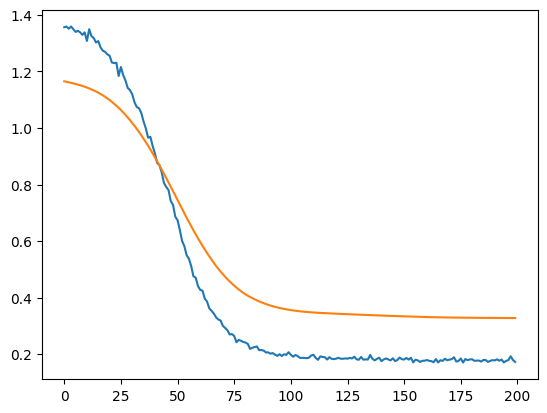

In [19]:
model_1, forecast_1 = NNprophet(aggregated_df, val_df)

In [20]:
res = forecast_1[['ds', 'yhat1']]
res

,ds,yhat1
0,2020-10-06,0.078258
1,2020-10-07,0.116452
2,2020-10-08,0.098077
3,2020-10-09,0.028388
4,2020-10-10,0.042293
5,2020-10-11,0.080735
6,2020-10-12,0.088379
7,2020-10-13,0.085720
8,2020-10-14,0.119527
9,2020-10-15,0.105529


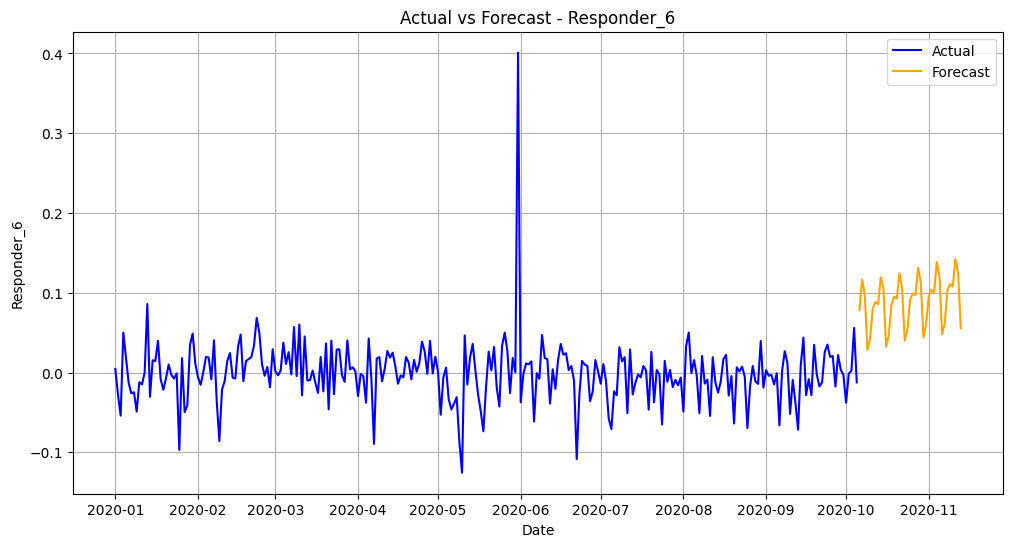

In [21]:
# Step 3: Plot actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['ds'], aggregated_df['y'], label='Actual', color='blue')
plt.plot(forecast_1['ds'], forecast_1['yhat1'], label='Forecast', color='orange')
#plt.fill_between(
    #forecast['ds'],
    #forecast['yhat_lower'],
    #forecast['yhat_upper'],
    #color='orange',
    #alpha=0.3,
    #label='Uncertainty Interval'
#)
plt.legend()
plt.title("Actual vs Forecast - Responder_6")
plt.xlabel("Date")
plt.ylabel("Responder_6")
plt.grid()
plt.show()

In [22]:
# Step 4: Analyze model components
#model_1.plot_components(forecast_1)
#plt.show()

# Forecast Daily Data

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency m is different than major frequency T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency m is different than major frequency T
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.436]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - m
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.436]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - m


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


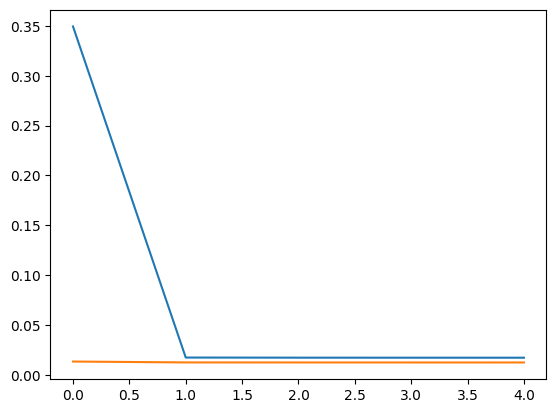

In [23]:
# 데이터를 줄임으로 용량 문제는 해결했다. 

model_2, forecast_2 = NNprophet(daily_df, val_daily_df, freq_ = 'm', epochs_ = 5)

In [24]:
res_2 = forecast_2[['ds', 'yhat1']]
res_2 #왜 음수만 나오지?

,ds,yhat1
0,2021-11-30 10:39:00,0.008659
1,2021-12-31 10:39:00,-0.005360
2,2022-01-31 10:39:00,-0.006130
3,2022-02-28 10:39:00,-0.004968
4,2022-03-31 10:39:00,0.025584
5,2022-04-30 10:39:00,0.033717
6,2022-05-31 10:39:00,0.015996
7,2022-06-30 10:39:00,0.029362
8,2022-07-31 10:39:00,0.020583
9,2022-08-31 10:39:00,0.016193


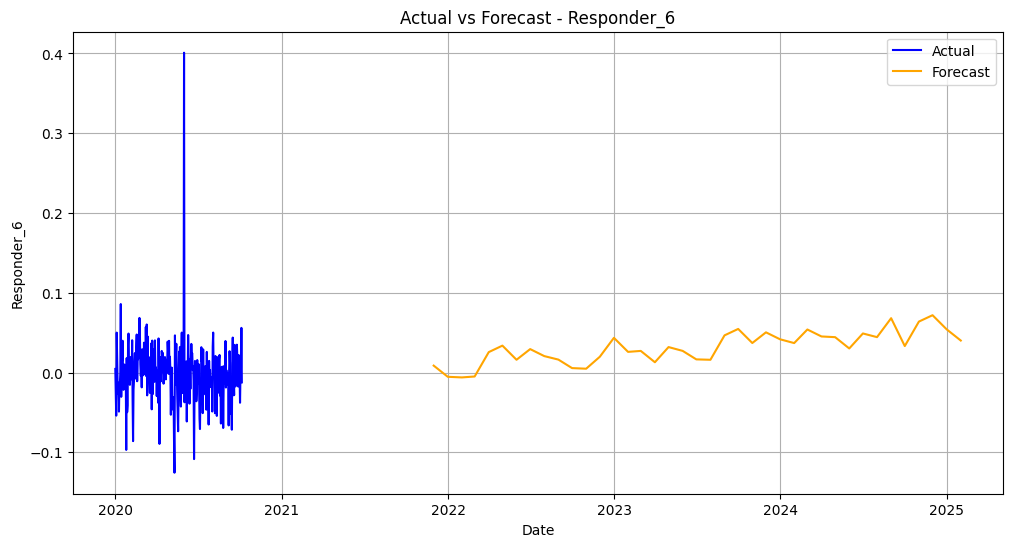

In [25]:
# Step 3: Plot actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['ds'], aggregated_df['y'], label='Actual', color='blue')
plt.plot(forecast_2['ds'], forecast_2['yhat1'], label='Forecast', color='orange')
#plt.fill_between(
    #forecast['ds'],
    #forecast['yhat_lower'],
    #forecast['yhat_upper'],
    #color='orange',
    #alpha=0.3,
    #label='Uncertainty Interval'
#)
plt.legend()
plt.title("Actual vs Forecast - Responder_6")
plt.xlabel("Date")
plt.ylabel("Responder_6")
plt.grid()
plt.show()

# NNprophet V2 try - with other features

In [26]:
model_2, forecast_2 = NNprophet_v2(aggregated_df, val_df, additional_features = mean_feature)

AttributeError: 'NeuralProphet' object has no attribute 'add_regressor'

In [ ]:
forecast_2

# submit - HOW??

In [ ]:
import os
import kaggle_evaluation.jane_street_inference_server

lags_ : pl.DataFrame | None = None


# Replace this function with your inference code.
# You can return either a Pandas or Polars dataframe, though Polars is recommended.
# Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global lags_
    if lags is not None:
        lags_ = lags

    # Replace this section with your own predictions
    predictions = model_2.select(
        'row_id',
        pl.lit(0.0).alias('responder_6'),
    )

    if isinstance(predictions, pl.DataFrame):
        assert predictions.columns == ['row_id', 'responder_6']
    elif isinstance(predictions, pd.DataFrame):
        assert (predictions.columns == ['row_id', 'responder_6']).all()
    else:
        raise TypeError('The predict function must return a DataFrame')
    # Confirm has as many rows as the test data.
    assert len(predictions) == len(test)

    return predictions

In [ ]:
import kaggle_evaluation.jane_street_inference_server

inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-realtime-marketdata-forecasting/test.parquet',
            '/kaggle/input/jane-street-realtime-marketdata-forecasting/lags.parquet',
        )
    )